In [245]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Reduced units
T_star = 1.5  # Reduced temperature
n_star = 0.9  # Reduced density
num_molecules = 100

# Calculate box size for the given reduced density in 3D
box_area = num_molecules / n_star
box_size = box_area ** (1/3)  # Since area = length^3 in 3D
kT = T_star  # epsilon is 1 in reduced units

# Maximum displacement in a single step
max_displacement = 0.1

# Initialize positions in a 2D lattice
np.random.seed(0)
positions = np.random.rand(num_molecules, 3) * box_size

def lennard_jones_potential(r):
    """ Calculate Lennard-Jones potential for a distance r in reduced units """
    r6 = (1 / r)**6  # sigma is 1 in reduced units
    r12 = r6**2
    return 4 * (r12 - r6)  # epsilon is 1 in reduced units

def calc_distances(positions, box_length):
    """Calculate all pairwise distances using broadcasting and taking into account periodic boundary conditions."""
    # Compute all pairwise distances using broadcasting
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]

    # Apply periodic boundary conditions
    diff = diff - np.rint(diff / box_length) * box_length

    # Calculate distances
    distances = np.sqrt(np.sum(diff**2, axis=-1))
    return distances

def total_potential_energy(positions):
    distances = calc_distances(positions, box_size)

    # Avoid division by zero and self-interactions
    np.fill_diagonal(distances, np.inf)
    
    # Take only the upper triangle of the distance matrix
    distances = distances[np.triu_indices(num_molecules, k=1)]

    # Vectorized Lennard-Jones potential calculation
    return np.sum(lennard_jones_potential(distances)) 

def metropolis_step(positions, total_energy, molecule_idx):
    """ Perform one step of the Metropolis algorithm """
    # Choose a random molecule
    old_position = positions[molecule_idx].copy()

    # Move the molecule to a new position
    displacement = (np.random.rand(3) - 0.5) * max_displacement
    positions[molecule_idx] += displacement

    # Apply periodic boundary conditions
    positions[molecule_idx] %= box_size

    # Calculate the energy change
    new_energy = total_potential_energy(positions)
    delta_energy = new_energy - total_energy

    # Metropolis criterion
    if delta_energy > 0 and -delta_energy / kT < np.log(np.random.rand()):
        # Reject the move, revert to the old position
        positions[molecule_idx] = old_position
    else:
        # Accept the move, update total energy
        total_energy = new_energy

    return positions, total_energy

In [246]:
# Initialize the total energy
total_energy = total_potential_energy(positions)
total_energy_history = [total_energy]

# Number of steps for the simulation
num_steps = 2000

# Perform the simulation
positions_history = [positions.copy()]
for step in range(1, num_steps * num_molecules):
    positions, total_energy = metropolis_step(positions, total_energy, step % num_molecules)
    positions_history.append(positions.copy())
    if step % num_molecules == 0:
        total_energy_history.append(total_energy)


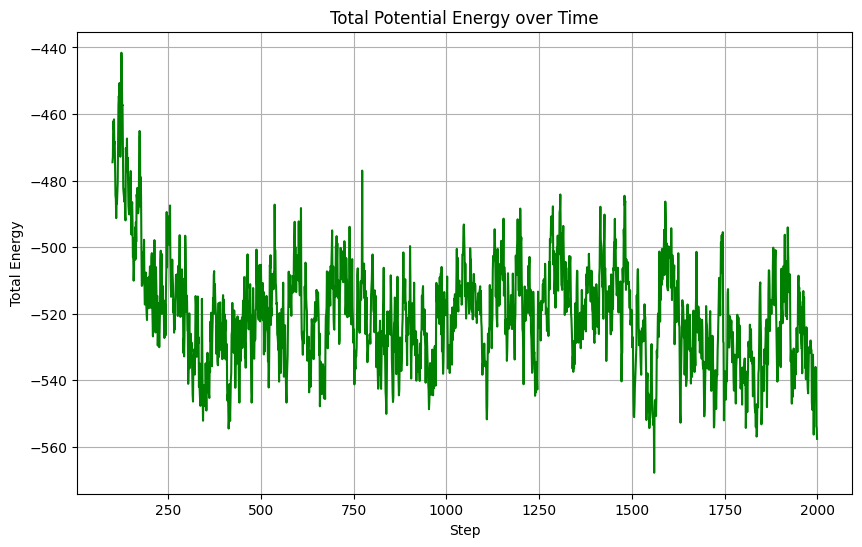

In [247]:
# Plotting the total energy over time
plt.figure(figsize=(10, 6))
plt.plot(range(100, len(total_energy_history)), total_energy_history[100:], color='green')
plt.title("Total Potential Energy over Time")
plt.xlabel("Step")
plt.ylabel("Total Energy")
plt.grid(True)
plt.show()

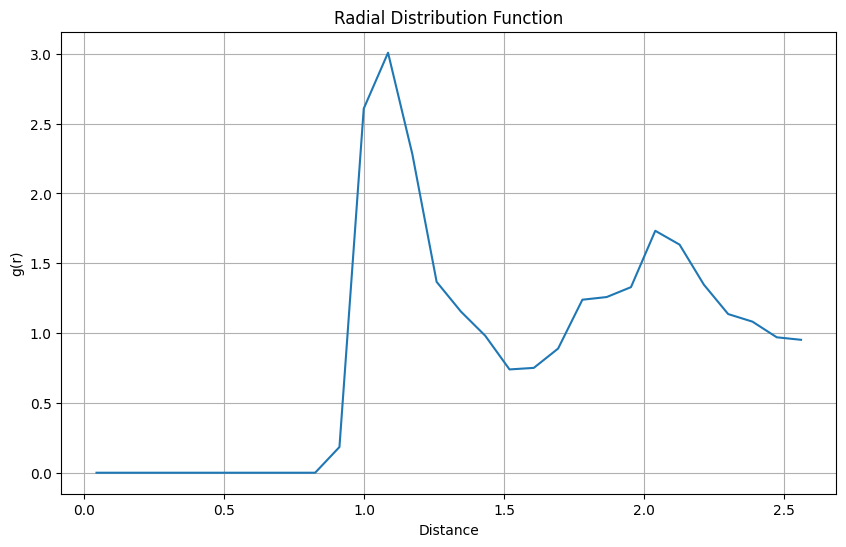

In [258]:
# This rdf is in a 3D box therefore the histogram is in 3D
def compute_rdf_hist(positions, box_size, num_bins=100, max_distance=box_size / 2):
    """ Compute the radial distribution function from a set of positions """
    # Calculate all pairwise distances
    distances = calc_distances(positions, box_size)

    # Avoid division by zero and self-interactions
    np.fill_diagonal(distances, np.inf)

    # Take only the upper triangle of the distance matrix
    distances = distances[np.triu_indices(num_molecules, k=1)]

    # Bin the distances
    rdf_hist, bin_edges = np.histogram(distances, bins=num_bins, range=(0, max_distance))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Normalize the histogram
    density = num_molecules / box_size**3
    normalization_factor = density * 4 * np.pi * bin_centers**2 * (bin_edges[1] - bin_edges[0])
    rdf_hist = rdf_hist / normalization_factor

    return bin_centers, rdf_hist

final_positions = positions_history[-1]
bin_centers, rdf_hist = compute_rdf_hist(final_positions, box_size, 30, box_size / 2 + 0.2)

# Plotting the radial distribution function
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, rdf_hist/40)
plt.title("Radial Distribution Function")
plt.xlabel("Distance")
plt.ylabel("g(r)")
plt.grid(True)
plt.show()


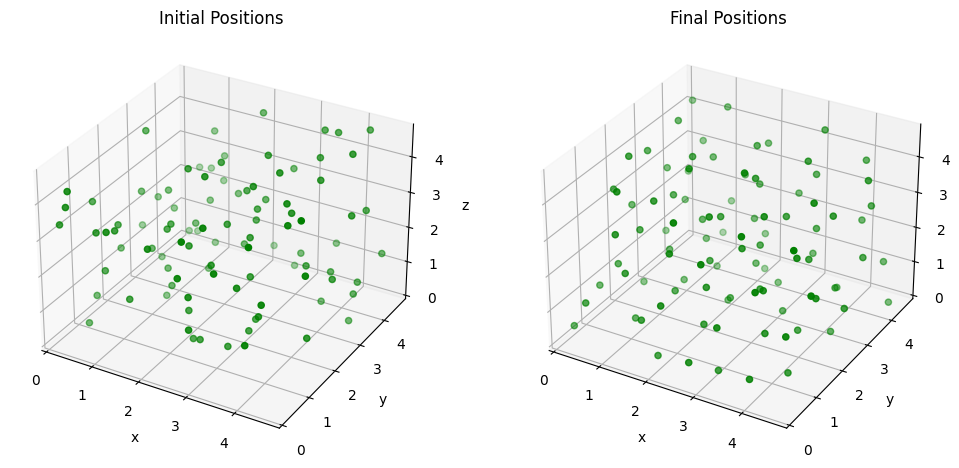

In [250]:
# Plot the initial and final positions of the molecules
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(positions_history[0][:, 0], positions_history[0][:, 1], positions_history[0][:, 2], color='green')
ax1.set_title("Initial Positions")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_xlim(0, box_size)
ax1.set_ylim(0, box_size)
ax1.set_zlim(0, box_size)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(positions_history[-1][:, 0], positions_history[-1][:, 1], positions_history[-1][:, 2], color='green')
ax2.set_title("Final Positions")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_xlim(0, box_size)
ax2.set_ylim(0, box_size)
ax2.set_zlim(0, box_size)

plt.show()
